In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from lightgbm.sklearn import LGBMRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

# import other functions
from imputer import *
from feature_eng import *
from drop import *

## Summary

|Model| Test MAE| Test MSE|
|-----|---------|---------|
| Simple LR | 99.675 | 190.922| 
| Ridge regression| 99.631 |190.895|
| Simple LGBM | 53.161 | 110.994 |
| LGBM with gridsearch | 
| LGBM with log transformed y | 51.2 | NA |


**Comments -** 


In [2]:
df = pd.read_csv("../data/train_data.zip")

In [3]:
df.head()

,external_id,month,year,monthly_number_of_sessions,monthly_unique_sessions,monthly_repeated_sessions,monthly_avg_length_of_session,monthly_avg_light_activity,monthly_avg_moderate_activity,monthly_avg_vigorous_activity,...,avg_wind_9_10,avg_wind_10_11,avg_wind_11_12,avg_wind_12_above,perfect_days,unacast_session_count,hpi,state_and_local_amount_per_capita,state_amount_per_capita,local_amount_per_capita
0,1804425,8,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,90.0,244.20,0.157475,0.009783,0.147692
1,1812706,2,2019,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,27.0,258.95,0.157475,0.009783,0.147692
2,1812706,3,2019,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,27.0,258.95,0.157475,0.009783,0.147692
3,1812706,11,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,24.0,258.95,0.157475,0.009783,0.147692
4,1812706,9,2018,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,258.95,0.157475,0.009783,0.147692


## Pre-processing data

In [4]:
# drop rows missing target variable
df = drop_missing_unacast(df)

# create X and y
X = df.drop(columns = ['unacast_session_count'], axis=1)
y = df.loc[:, 'unacast_session_count']
# split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                    test_size=0.2,
                                                      random_state=2020)
# impute NaN values
result = impute_data(X_train, X_valid)
X_train = result[0]
X_valid = result[1] 
# perform feature eng
X_train = comb_cols(X_train)
X_valid = comb_cols(X_valid)
# perform dropping
X_train = drop_columns(X_train)
X_valid = drop_columns(X_valid)

# perform OHE (climate, density_class, income_class)
X_train_valid = clean_categorical(X_train, X_valid)
X_train = X_train_valid[0]
X_valid = X_train_valid[1]

In [5]:
def show_scores(model, X, y, error = 'mse'):
    """
    Shows the mean squared error and mean absolute error for a given model
    and predictors and response
    
    Parameters
    ----------
    model: The sklearn model object
    X: numpy.ndarray        
        The predictors(independent variables) part of the data
    y: numpy.ndarray
        The response(target variable)of the data
    error: string,
        'mse' or 'mae' depending upon the type of error
        we are interested in
        
    Returns
    ------- 
    """            
    y_preds = model.predict(X)
    
    if error == 'mse':
        rmse = mean_squared_error(y, y_preds, squared = False)
        print("Root mean squared error: %0.3f" % rmse)
        return
    if error == 'mae':
        mae = mean_absolute_error(y, y_preds)
        print("Mean absolute error: %0.3f" % mae)
        return
    else:
        print("Wrong choice")

## Modelling with Linear regression

In [9]:
cols_sum = np.sum(X_train, axis = 0)
cols_sum[cols_sum ==0]

monthly_rain               0.0
monthly_avg_rain_length    0.0
dtype: float64

In [6]:
print(X_train.shape)
print(X_valid.shape)

(39592, 632)
(9898, 632)


### 1. Linear Regression

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Simple linear regression scores: ')
print('Train error: ')
show_scores(lr, X_train, y_train, 'mse')

print('Test error: ')    
show_scores(lr, X_valid, y_valid, 'mse')

Simple linear regression scores: 
Train error: 
Root mean squared error: 182.973
Test error: 
Root mean squared error: 190.922


In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Simple linear regression scores: ')
print('Train error: ')
show_scores(lr, X_train, y_train, 'mae')

print('Test error: ')    
show_scores(lr, X_valid, y_valid, 'mae')

Simple linear regression scores: 
Train error: 
Mean absolute error: 96.979
Test error: 
Mean absolute error: 99.675


In [16]:
y_pred = lr.predict(X_valid)
y_pred[y_pred < 0].shape

(1284,)

### Observations 
- Better than last run. Proabably due to improved target.


### 4. Ridge L2

In [18]:
ridge_lr = Ridge(max_iter=2000, random_state = 2020)
ridge_lr.fit(X_train, y_train)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(ridge_lr, X_train, y_train)

print('Test error: ')    
show_scores(ridge_lr, X_valid, y_valid)

C:\Users\saura\.virtualenvs\capstone_machine_learning-a37y-TX3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.07072e-20): result may not be accurate.
  overwrite_a=True).T


Ridge regression scores: 
Train error: 
Root mean squared error: 182.989
Test error: 
Root mean squared error: 190.895


In [22]:
ridge_lr = Ridge(max_iter=2000, random_state = 2020)
ridge_lr.fit(X_train, y_train)
print('Ridge regression scores: ')
print('Train error: ')
show_scores(ridge_lr, X_train, y_train, 'mae')

print('Test error: ')    
show_scores(ridge_lr, X_valid, y_valid, 'mae')

C:\Users\saura\.virtualenvs\capstone_machine_learning-a37y-TX3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.07072e-20): result may not be accurate.
  overwrite_a=True).T


Ridge regression scores: 
Train error: 
Mean absolute error: 96.934
Test error: 
Mean absolute error: 99.631


### Observations
- Same as LR


## LGBM on this data with Mean objective function

In [8]:
lgbm = LGBMRegressor(random_state = 2020)

lgbm.fit(X_train, y_train)

print('LGBM scores: ')

print('Train error: ')
show_scores(lgbm, X_train, y_train)

print('Test error: ')
show_scores(lgbm, X_valid, y_valid)

LGBM scores: 
Train error: 
Root mean squared error: 89.408
Test error: 
Root mean squared error: 110.994


**performing grid search**

In [12]:
params = {'max_depth' : [100, 500], 'n_estimators' : [100, 200] }

lgbm = LGBMRegressor(random_state = 2020)

mae_scorer = make_scorer(mean_absolute_error)

clf_lgbm = GridSearchCV(lgbm, params, scoring = mae_scorer, n_jobs = 16)

clf_lgbm.fit(X_train, y_train)
print('LGBM scores: ')
print('Train error: ')
show_scores(clf_lgbm, X_train, y_train)

print('Test error: ')
show_scores(clf_lgbm, X_valid, y_valid)

LGBM scores: 
Train error: 
Root mean squared error: 89.408
Test error: 
Root mean squared error: 110.994


In [13]:
print('Train error: ')
show_scores(clf_lgbm, X_train, y_train, 'mae')

print('Test error: ')
show_scores(clf_lgbm, X_valid, y_valid, 'mae')

Train error: 
Mean absolute error: 46.033
Test error: 
Mean absolute error: 50.208


In [14]:
clf_lgbm.best_params_

{'max_depth': 100, 'n_estimators': 100}

### Hyperparameter tuning using hyperopt - run on AWS EC2 only

In [17]:
import csv

# File to save first results
out_file = '../results/lgbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [58]:
import lightgbm as lgb
from hyperopt import STATUS_OK
from hyperopt import hp
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
import time

MAX_EVALS = 500

N = 5

# Create the dataset
train_set = lgb.Dataset(X_train, y_train)
iteration = 0
start = time.time()

def objective(params, n_folds = N):
    
    global iteration
    
    params['objective'] = 'regression'
    print(params)
    cv_results = lgb.cv(params, train_set, nfold = N, stratified=False,
                        early_stopping_rounds = 100, metrics = 'mae', seed = 50)
    
    loss = max(cv_results['l1-mean'])
    
    # computing runtime
    run_time = time.time() - start
    
    # Boosting rounds that returned the highest cv score
    n_estimators = int(np.argmax(cv_results['l1-mean']) + 1)

    # Write to the csv file ('a' means append)
    out_file = '../results/lgbm_trials.csv'
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, iteration, n_estimators, run_time])
    of_connection.close()
    
    iteration+=1
    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

space = {
    'boosting_type': hp.choice('boosting_type',['gbdt', 'dart', 'goss']),
    'num_leaves': hp.choice('num_leaves', [50, 70, 100, 150, 200, 300]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'max_dept': hp.quniform('max_dept', 50, 200, 5)
}

# Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, 
            max_evals = MAX_EVALS, trials = bayes_trials)

{'boosting_type': 'goss', 'learning_rate': 0.03183805705025734, 'max_dept': 155.0, 'num_leaves': 200, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.024214896327248357, 'max_dept': 100.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.06368097971321597, 'max_dept': 60.0, 'num_leaves': 150, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.046370247251339126, 'max_dept': 60.0, 'num_leaves': 150, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.0383698171002965, 'max_dept': 110.0, 'num_leaves': 150, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.024050460617609765, 'max_dept': 115.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.016083701327428673, 'max_dept': 180.0, 'num_leaves': 200, 'objective': 'regression'}
{'boosting_type': 'dart', 'learning_rate': 0.020108895325379204, 'max_dept': 115.0, 'num_leaves': 

/home/ubuntu/.local/share/virtualenvs/capstone_machine_learning-9cUIoDBU/lib/python3.7/site-packages/lightgbm/callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



{'boosting_type': 'dart', 'learning_rate': 0.03735590575120143, 'max_dept': 125.0, 'num_leaves': 100, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.03862064318068387, 'max_dept': 160.0, 'num_leaves': 300, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.05937573444340072, 'max_dept': 120.0, 'num_leaves': 150, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.018842923052891866, 'max_dept': 150.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'dart', 'learning_rate': 0.017341979262825123, 'max_dept': 140.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'dart', 'learning_rate': 0.010927427841269216, 'max_dept': 165.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.01308419895509093, 'max_dept': 100.0, 'num_leaves': 100, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.11342403147451176, 'max_dept': 60.0, 'num_leaves': 1

{'boosting_type': 'gbdt', 'learning_rate': 0.09016248961256623, 'max_dept': 120.0, 'num_leaves': 150, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.1654431549132049, 'max_dept': 115.0, 'num_leaves': 200, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.10149258164775274, 'max_dept': 100.0, 'num_leaves': 300, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.1960192339693318, 'max_dept': 140.0, 'num_leaves': 150, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.13306288641251207, 'max_dept': 165.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.1989273185737521, 'max_dept': 145.0, 'num_leaves': 200, 'objective': 'regression'}
{'boosting_type': 'dart', 'learning_rate': 0.11386623003132408, 'max_dept': 200.0, 'num_leaves': 200, 'objective': 'regression'}
{'boosting_type': 'gbdt', 'learning_rate': 0.16958556301100564, 'max_dept': 160.0, 'num_leaves': 200,

{'boosting_type': 'goss', 'learning_rate': 0.09660954850878471, 'max_dept': 60.0, 'num_leaves': 50, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.03164450558591146, 'max_dept': 100.0, 'num_leaves': 300, 'objective': 'regression'}
{'boosting_type': 'dart', 'learning_rate': 0.11529796157448825, 'max_dept': 65.0, 'num_leaves': 100, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.08723111061193087, 'max_dept': 75.0, 'num_leaves': 300, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.19972641380659503, 'max_dept': 105.0, 'num_leaves': 300, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.14205503297676522, 'max_dept': 115.0, 'num_leaves': 300, 'objective': 'regression'}
{'boosting_type': 'goss', 'learning_rate': 0.18158422102643548, 'max_dept': 105.0, 'num_leaves': 70, 'objective': 'regression'}
{'boosting_type': 'dart', 'learning_rate': 0.08146230997646264, 'max_dept': 95.0, 'num_leaves': 50, 'o

KeyboardInterrupt: 

In [59]:
df_lgbm = pd.read_csv('../results/lgbm_trials.csv')
df_lgbm.head()

,loss,params,iteration,estimators,train_time
0,119.060126,"{'boosting_type': 'goss', 'learning_rate': 0.0...",0,1,45.307489
1,120.200140,"{'boosting_type': 'goss', 'learning_rate': 0.0...",1,1,60.516712
2,116.636390,"{'boosting_type': 'goss', 'learning_rate': 0.0...",2,1,89.212210
3,118.014573,"{'boosting_type': 'goss', 'learning_rate': 0.0...",3,1,120.791389
4,118.656670,"{'boosting_type': 'gbdt', 'learning_rate': 0.0...",4,1,165.154807


In [60]:
compression_opts = dict(method='zip',archive_name='out.csv')  
df_lgbm.to_csv("../results/lgbm_trials.zip", index = False, compression=compression_opts)

## LGBM on this data with Median objective function

In [13]:
#fitting lgbm with MAE without scaling
lgbm = LGBMRegressor(objective = 'mae', random_state = 2020)

lgbm.fit(X_train, y_train)
print('LGBM scores: ')
print('Train error: ')
show_scores(lgbm, X_train, y_train, 'mae')

print('Test error: ')
show_scores(lgbm, X_valid, y_valid, 'mae')

LGBM scores: 
Train error: 
Mean absolute error: 49.819
Test error: 
Mean absolute error: 53.161


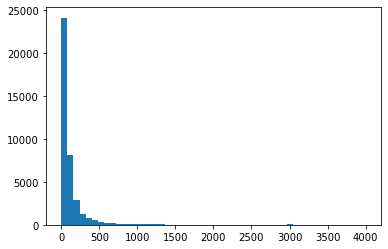

In [18]:
plt.hist(y_train, bins = 50)
plt.show()

## LGBM with log transformed target and Median objective function

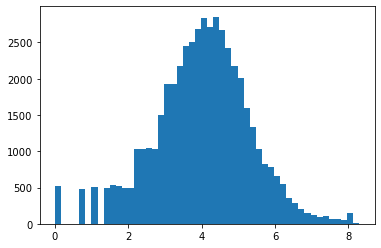

In [12]:
y_log = np.log(y)

plt.hist(y_log, bins = 50)
plt.show()

In [16]:
y_train_log = np.log(y_train)

lgbm = LGBMRegressor(objective = 'mae', random_state = 2020)
lgbm.fit(X_train, y_train_log)

print('LGBM scores: ')

print('Train error: ')
y_log_pred_train = lgbm.predict(X_train)
y_preds_train = np.exp(y_log_pred_train)

mae = mean_absolute_error(y_train, y_preds_train)
print("Mean absolute error: %0.3f" % mae)

print('Test error: ')

y_log_pred_valid = lgbm.predict(X_valid)
y_preds_valid = np.exp(y_log_pred_valid)

mae = mean_absolute_error(y_valid, y_preds_valid)
print("Mean absolute error: %0.3f" % mae)


LGBM scores: 
Train error: 
Mean absolute error: 47.603
Test error: 
Mean absolute error: 51.274


### Ensembling of lgbm, catboost, xgboost

In [6]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

xgbr = XGBRegressor(objective = 'reg:linear', random_state = 2020)
xgbr.fit(X_train, y_train)

catb = CatBoostRegressor(objective = 'MAE', random_seed = 2020)
catb.fit(X_train, y_train)

lgbm = LGBMRegressor(objective = 'mae', random_state = 2020)
lgbm.fit(X_train, y_train)

y_pred_xg = xgbr.predict(X_valid)
y_pred_lg = lgbm.predict(X_valid)
y_pred_cat = catb.predict(X_valid)

print(time.time() - t0)


In [57]:
y_preds = pd.DataFrame({'xg' : y_pred_xg,
                        'lg' : y_pred_lg,
                        'cat' : y_pred_cat})

y_preds_valid = np.max(y_preds, axis = 1)

y_preds_valid.shape

(9898,)

C:\Users\saura\.virtualenvs\capstone_machine_learning-a37y-TX3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\saura\.virtualenvs\capstone_machine_learning-a37y-TX3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


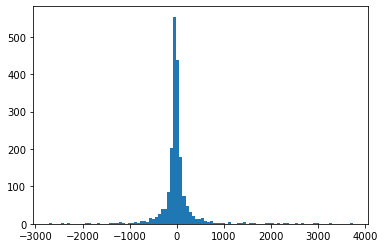

In [59]:
plt.hist(y_valid - y_preds_valid, bins = 100)
plt.show()

In [60]:
mae = mean_absolute_error(y_valid, y_preds_valid)
print("Mean absolute error: %0.3f" % mae)


Mean absolute error: 45.330


## Running LGBM with best hyper parameters

In [7]:
lgbm = LGBMRegressor(learning_rate = 0.19981387712135354 , max_dept = 105.0, num_leaves = 300, random_state = 2020)

lgbm.fit(X_train, y_train)

print('LGBM scores: ')

print('Train error: ')
show_scores(lgbm, X_train, y_train)

print('Test error: ')
show_scores(lgbm, X_valid, y_valid)

LGBM scores: 
Train error: 
Root mean squared error: 29.118
Test error: 
Root mean squared error: 97.060


In [9]:
print('Train error: ')
show_scores(lgbm, X_train, y_train, 'mae')

print('Test error: ')
show_scores(lgbm, X_valid, y_valid, 'mae')

Train error: 
Mean absolute error: 14.442
Test error: 
Mean absolute error: 40.864


In [15]:
temp_train = pd.concat([X_train, y_train], axis = 1)
temp_valid = pd.concat([X_valid, y_valid], axis = 1) 

In [17]:
temp_valid.shape

(9898, 633)

In [18]:
compression_opts = dict(method='zip',archive_name='train_data.csv')  
temp_train.to_csv("train_data.zip", index = False, compression=compression_opts)

compression_opts = dict(method='zip',archive_name='valid_data.csv')  
temp_valid.to_csv("valid_data.zip", index = False, compression=compression_opts)
